In [1]:
import sys
import os
IMATOOLS_DIR = os.getcwd()+'/..'
sys.path.insert(1, IMATOOLS_DIR) 


from imatools.common import ioutils as iou
from imatools.common import vtktools as vtku

import pandas as pd 
import numpy as np


In [2]:

# Locations of hard drive based on platform
dirdic={'macOS'   : '/Volumes/sandisk', 
        'Linux'   : '/media/jsl19/sandisk' , 
        'Windows' : 'D:/'}

p2f = iou.fullfile(dirdic[iou.chooseplatform()], '09-dnav_vs_inav/umc')
name = 'spatial_correspondence.csv'

df = pd.read_csv(iou.fullfile(p2f, 'local',name), skipinitialspace=True)
df_stats = pd.read_csv(iou.fullfile(p2f, 'results_local', 'stats.csv'), skipinitialspace=True)

In [3]:
def get_data_from_vtk_path(path, type='cell') : 
    msh = vtku.readVtk(path)
    if type=='cell' : 
        dat = vtku.convertCellDataToNpArray(msh, 'scalars')
    else : # type=='point'
        dat = vtku.convertPointDataToNpArray(msh, 'scalars')
    return dat 

CX = ['2', '5', '6', '8', '9', '11', '12', '13', '15', '16', '17', '18', '19', '21', '22', '24', '26', '7', '10', '14', '20', '23', '25']

xnav = lambda x : 'LGE_{}NAV'.format(x)
dname = 'Normalised_IIR_MaxScar-single-voxel.vtk'
iname = 'Scalars_i_on_d.vtk'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sstat

# cx = 0
fig, ax = plt.subplots(4, 6, sharex=True, sharey=True,squeeze=True)
fig.set_figwidth(18)
fig.set_figheight(12)

sns.set_palette('colorblind')

corrs = np.zeros(len(CX))

for cx in range(len(CX)) : 
    ddat = get_data_from_vtk_path(iou.fullfile(p2f, 'local', CX[cx], xnav('d'), 'OUTPUT', dname))
    idat = get_data_from_vtk_path(iou.fullfile(p2f, 'local', CX[cx], iname))

    df_test = pd.DataFrame({
        'scalars': ddat.tolist() + idat.tolist(), 
        'nav': ['dNAV'] * len(ddat) + ['iNAV']*len(idat)
        })

    subs = np.unravel_index(cx, (4,6))
    corrs[cx] = sstat.pearsonr(ddat, idat).statistic

    ax[subs].set_title('Case {} (r={:.2f})'.format(CX[cx], corrs[cx]))
    sns.histplot(ax=ax[subs], data=df_test, x='scalars', hue='nav', 
                element='step', bins=50, multiple='dodge', stat='count', 
                binrange=(0, 2.5))


# plt.savefig(iou.fullfile(iou.fullfile(p2f, 'local', 'scalar_comparison.eps')))



In [ ]:
case_mean_diff = np.zeros(len(CX))
for cx in range(len(CX)):
    ddat = get_data_from_vtk_path(iou.fullfile(p2f, 'local', CX[cx], xnav('d'), 'OUTPUT', dname))
    idat = get_data_from_vtk_path(iou.fullfile(p2f, 'local', CX[cx], iname))

    case_mean_diff[cx] = np.mean(np.subtract(ddat, idat))


sns.boxplot(y=case_mean_diff)
print(sstat.ttest_1samp(a=case_mean_diff, popmean=0))

In [ ]:
# import scipy.stats as sstat
# help(sstat.ttest_1samp)

def print_stats(arr) :
    print('{} +/- {}'.format(np.mean(arr), np.std(arr)))

print_stats(case_mean_diff)
print_stats(corrs)
print(iou.get_boxplot_values(corrs))
# print('{} +/- {}'.format(np.mean(case_mean_diff), np.std(case_mean_diff)))
# print('{} +/- {}'.format(np.mean(case_mean_diff), np.std(case_mean_diff)))
print('')
# sns.histplot(x=case_mean_diff, bins=20)

In [ ]:
# 
#print('{:.2f} +/- {:.2f}'.format(np.nanmean(corrs),np.nanstd(corrs)))

np.sort(CX)

In [ ]:
# import matplotlib.pyplot as plt

# df_stats['LGE_TYPE']=='iNAV'], x='CASE', y='MEAN_BP', yerr='SDEV_BP', fmt='or')
# else :
#     sns.scatterplot(data=df_stats, x='CASE', y='FIB_SCORE ', hue='LGE_TYPE')

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

x=np.linspace(0, 0.7, 10)
y=x

sns.set_palette(palette='Pastel1')
sns.scatterplot(data=df, x='fibrosis_d', y='fibrosis_i', hue='th_inav', hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])
plt.plot(x,y)


In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')

sns.boxplot(ax=ax[0], x=df['th_inav'], y=(df['fibrosis_d']-df['fibrosis_i'])
            ** 2, order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265], 
            whis=1)
sns.scatterplot(ax=ax[1], data=df, x='fibrosis_d', y='fibrosis_i', hue='th_inav', hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])
plt.plot()

ax[0].set_xlabel('iNAV IIR Threshold')
ax[0].set_ylabel('Mean Squared Error')
ax[1].set_xlabel('dNAV Fibrosis %')
ax[1].set_ylabel('iNAV Fibrosis %')

# sns.lmplot( data=df, x='fibrosis_d', y='fibrosis_i', col='th_inav', col_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])

In [ ]:

fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')
sns.boxplot(ax=ax, data=df, 
    x='perf_name', y='performance', hue='th_inav', whis=1,
    hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])

plt.savefig(iou.fullfile(p2f, 'performance.eps'))


In [ ]:
metric_name = 'dice'
th = [1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265]

print(metric_name)
for threshold in th :
    # threshold = 1.1205
    metric = df['performance']
    thresh = df['th_inav']

    metric = metric[df['perf_name']==metric_name]
    thresh = thresh[df['perf_name']==metric_name]

    metric = metric[thresh==threshold]

    print('{:.3f} (+/-{:.3f})'.format(np.mean(metric), np.std(metric)))


# Point analysis 

+ Load a case 
+ Move cell data to point data 
+ Explore

**Sanity check**: check that the correct data are being retrieved - _PASSED_

Compare the point data coming out of the mesh to the point data after converting cell to point.

In [ ]:
cx = 2

dpath = iou.fullfile(p2f, 'local', CX[cx], xnav('d'), 'OUTPUT', dname)
ipath = iou.fullfile(p2f, 'local', CX[cx], iname) 

dmsh = vtku.readVtk(dpath)
imsh = vtku.readVtk(ipath)
ddat = vtku.convertPointDataToNpArray(dmsh, 'scalars')
idat = vtku.convertPointDataToNpArray(imsh, 'scalars')

dmsh_pts = vtku.set_cell_to_point_data(dmsh, 'scalars')
imsh_pts = vtku.set_cell_to_point_data(imsh, 'scalars')
ddat_pts = vtku.convertPointDataToNpArray(dmsh_pts, 'scalars')
idat_pts = vtku.convertPointDataToNpArray(imsh_pts, 'scalars')

print('len idat: {}, len idat_pts: {}'.format(len(idat), len(idat_pts)))
print('idat - idat_pts : {}'.format(np.mean(np.subtract(idat, idat_pts))))
# ddat = get_data_from_vtk_path(dpath)
# idat = get_data_from_vtk_path(ipath)


Create all point-based `scalars_i_on_d` files. 

> NOTE: dNAV normalised scalars already have the point data saved in them.

In [ ]:
# dpath = iou.fullfile(p2f, 'local', CX[cx], xnav('d'), 'OUTPUT', dname)
# cx = 2
def fileparts(pth):
    directory = os.path.dirname(pth)
    fname_ext = os.path.basename(pth)
    aux = os.path.splitext(fname_ext)
    fname = aux[0]
    ext = aux[1]

    return directory, fname, ext


for cx in range(len(CX)) : 
    
    ipath = iou.fullfile(p2f, 'local', CX[cx], iname)
    imsh = vtku.readVtk(ipath)
    imsh_pts = vtku.set_cell_to_point_data(imsh, 'scalars')

    di, fn, xt = fileparts(ipath)
    iname_pts = fn + "_pts"
    vtku.writeVtk(imsh_pts, di, iname_pts)


+ We ran the `10_project_inav_on_dnav.sh` script, commenting the projection (as we do not need to create the `scalars_i_on_d` files). 
+ Once done, we rerun some of the calculations done before
+ see below

In [ ]:
p2f = iou.fullfile(dirdic[iou.chooseplatform()], '09-dnav_vs_inav/umc')
name = 'spatial_correspondence_pts.csv'

df_pts = pd.read_csv(iou.fullfile(p2f, 'local', name), skipinitialspace=True)

df_pts


In [ ]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

x=np.linspace(0, 0.7, 10)
y=x

sns.set_palette(palette='Pastel1')
sns.scatterplot(data=df_pts, x='fibrosis_d', y='fibrosis_i', hue='th_inav', hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])
plt.plot(x,y)

In [ ]:
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')
sns.boxplot(ax=ax, data=df_pts,
            x='perf_name', y='performance', hue='th_inav', whis=1,
            hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])

# plt.savefig(iou.fullfile(p2f, 'performance.eps'))


In [ ]:
metric_name = 'dice'
th = [1.1205,1.13, 1.1367, 1.1504, 1.2, 1.265]

print(metric_name)
for threshold in th:
    # threshold = 1.1205
    metric = df_pts['performance']
    thresh = df_pts['th_inav']

    metric = metric[df_pts['perf_name'] == metric_name]
    thresh = thresh[df_pts['perf_name'] == metric_name]

    metric = metric[thresh == threshold]

    print('{:.3f} (+/-{:.3f})'.format(np.mean(metric), np.std(metric)))


# Sweep thresholds - get fibrosis scores 

First get the point fibrosis scores from all dnavs

In [21]:
import numpy as np
dname = 'Normalised_IIR_MaxScar-single-voxel.vtk'
iname_pts = 'Scalars_i_on_d_pts.vtk'

sweep = np.arange(0.7, 1.59, 0.01)
len_sweep = len(sweep)

args_min = np.zeros((len(sweep), 1), dtype=int)

dfib_scores = np.zeros((len(CX), 1))
ifib_best_scores = np.zeros_like(dfib_scores)
ifib_best_thresholds = np.zeros_like(dfib_scores)
ifib_scores_1d2 = np.zeros_like(ifib_best_scores)

sq_err_1d2 = np.zeros_like(dfib_scores)
sq_err_best = np.zeros_like(dfib_scores)
for cx in range(len(CX)):
    dpath = iou.fullfile(p2f, 'local', CX[cx], xnav('d'), 'OUTPUT', dname)
    dmsh = vtku.readVtk(dpath)

    dfib_scores[cx] = vtku.fibrosis_score_point(dmsh, 1.2)

    ipath_pts = iou.fullfile(p2f, 'local', CX[cx], iname_pts)
    imsh_pts = vtku.readVtk(ipath_pts)

    sweep_scores = np.zeros((len_sweep, 1))
    for ix in range(len_sweep):
        sweep_scores[ix] = vtku.fibrosis_score_point(imsh_pts, sweep[ix])

    sq_err = np.power(sweep_scores-dfib_scores[cx], 2)
    args_min[cx] = np.argmin(sq_err)
    
    ifib_scores_1d2[cx] = sweep_scores[50] 
    sq_err_1d2[cx] = sq_err[50]

    ifib_best_thresholds[cx] = sweep[args_min[cx]]
    ifib_best_scores[cx] = sweep_scores[args_min[cx]]
    sq_err_best[cx] = sq_err[args_min[cx]]


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc872a10f10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc8729fc250>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc872a10d30>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc8744a86a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc872a797f0>],
 'means': []}

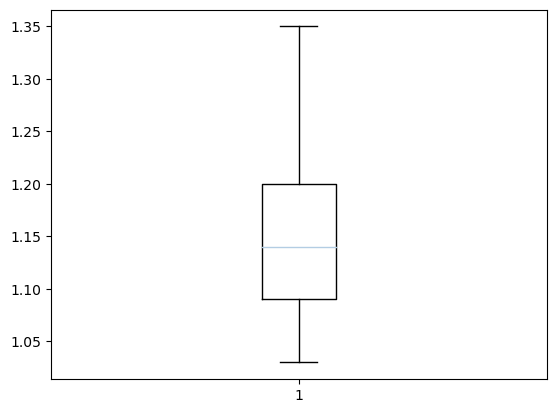

In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# # plt.scatter(x=dfib_scores, y=ifib_scores_1d2)
plt.boxplot(ifib_best_thresholds)

# # sns.set_palette(palette='Pastel1')
# # sns.scatterplot(x=dfib_scores, y=ifib_scores_1d2) 
# iou.get_boxplot_values(ifib_best_thresholds) # median = 1.14 
# np.mean(ifib_best_thresholds) # 1.15

Refined search: `1.05:0.0001:1.35`